In [118]:
import autoplier.model as ap
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, average_precision_score
from onto_lib import general_ontology_tools as got
import numpy as np#
import autoplier.plot as plot
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [2]:
import pandas as pd
import csv
pathway_genes = []
pathway_names = []

with open('data/c2.cp.v7.4.symbols.gmt', newline='\n') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        pathway_names += [row[0]]
        pathway_genes += [row[2:]]

In [3]:
import csv
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

In [4]:
mlb = MultiLabelBinarizer()
pathways = pd.DataFrame(mlb.fit_transform(pathway_genes), index = pathway_names, columns = mlb.classes_)

In [5]:
rnaseq = pd.read_csv("data/mat4.csv",index_col = 0).T

In [6]:
rnaseq

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,MIR6715B,RP11-434E6.5,MIR3116-2,RP11-158M9.1,MIR3202-2,CTD-2331H12.9,RP11-122G18.12,RP5-937E21.8,RP11-606M12.1,MIR4481
SRX890545,0.071963,0.068414,3.718085,2.184815,1.490935,6.995514,0.629519,3.892468,3.241940,2.960884,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.208610,0.086928,0.149827,0.997044
SRX1067711,0.033104,0.000000,3.743323,1.990195,1.780348,6.565519,0.045174,3.519702,3.266680,2.425106,...,0.0,0.0,0.0,0.084583,0.0,0.0,0.647963,0.000000,0.000000,0.000000
SRX1067710,0.233484,0.000000,3.376271,1.523096,0.611052,5.667817,0.013306,3.271395,3.490619,2.419673,...,0.0,0.0,0.0,0.073274,0.0,0.0,0.697612,0.000000,0.306894,0.000000
SRX762971,0.000000,0.000000,0.270898,0.272666,0.046180,4.310495,0.048563,0.505901,1.021726,0.468655,...,0.0,0.0,0.0,0.061147,0.0,0.0,0.751671,0.000000,0.000000,0.000000
SRX762970,0.000000,0.000000,0.000000,0.153331,0.029985,3.570165,0.012488,0.376561,0.298916,0.148210,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.520262,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX3399308,0.900313,0.000000,4.034299,2.548069,1.914284,6.135145,1.561809,3.504841,2.099581,2.509156,...,0.0,0.0,0.0,0.197238,0.0,0.0,0.976151,0.000000,0.455072,0.000000
SRX3399309,0.317015,0.000000,3.972622,2.634532,2.009371,6.394950,1.277340,3.693114,2.188385,2.900505,...,0.0,0.0,0.0,0.198363,0.0,0.0,1.115170,0.000000,0.386765,0.000000
SRX3399310,0.799190,0.000000,4.109202,2.661645,2.445280,6.295505,1.314905,3.792382,1.471354,3.156924,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.698829,0.000000,0.148570,0.000000
SRX3399311,0.044163,0.000000,4.007751,2.015217,1.989733,6.363111,0.788769,3.855940,2.337722,3.061316,...,0.0,0.0,0.0,0.071303,0.0,0.0,1.192115,0.715472,0.605566,3.314630


In [7]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=100, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

In [8]:
with open("data/bulk_labels.json", 'r') as f:
    labels = json.load(f)

In [10]:
sample2types_full = {
        sample: list(map(got.get_term_name, types_ids))
        for sample, types_ids in labels.items()
    }
mlb_full = MultiLabelBinarizer()

types_per_samples = rnaseq.index.map(sample2types_full).values
samples_dummies = pd.DataFrame(mlb_full.fit_transform(types_per_samples), columns=mlb_full.classes_,
                                      index=rnaseq.index)

celltypes = samples_dummies.columns.tolist()

type2samples = {
    type_: samples_dummies.index[samples_dummies[type_] == 1].tolist()
    for type_ in celltypes
}
types_sizes = samples_dummies.sum()
types_with_data = types_sizes.index.values
all_types = samples_dummies.columns

In [153]:
types_with_data

array(['B cell', 'Bm4 B cell', 'CD14-low, CD16-positive monocyte',
       'CD14-positive monocyte',
       'CD14-positive, CD16-negative classical monocyte',
       'CD14-positive, CD16-positive monocyte',
       'CD141-positive myeloid dendritic cell',
       'CD1c-positive myeloid dendritic cell',
       'CD4-positive helper T cell',
       'CD4-positive, CD25-positive, alpha-beta regulatory T cell',
       'CD4-positive, CXCR3-negative, CCR6-negative, alpha-beta T cell',
       'CD4-positive, alpha-beta T cell',
       'CD4-positive, alpha-beta memory T cell',
       'CD4-positive, alpha-beta thymocyte',
       'CD7-negative lymphoid progenitor OR granulocyte monocyte progenitor',
       'CD8-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta memory T cell',
       'CD8-positive, alpha-beta thymocyte',
       'CNS neuron (sensu Vertebrata)', 'IgD-negative memory B cell',
       'IgG memory B cell', 'IgM memory B cell', 'Kupffer cell',
       'Merkel cell', 'Sertoli cell'

In [84]:
with open('data/validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open('data/pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [144]:
def train_autoplier(X, pathways, seed, n_LVs):
    ap.set_seed_(seed)
    model = ap.autoPLIER(n_LVs, regval = 1.20E-7,learning_rate= 0.000156)
    model.fit(X, pathways, verbose=0, batch_size = None, callbacks = callbacks)
    Z = model.transform(X, pathways)
    
    print(ap.sparsity_epsilon(model.components_decomposition_, 1.0E-4))
    
    return Z, model

In [145]:
def compare_celltypes(celltype1, celltype2, pathways, seed, n_LVs):
    data_c1 = samples_dummies[celltype1][samples_dummies[celltype1] == 1]
    data_c2 = samples_dummies[celltype2][samples_dummies[celltype2] == 1]
    overlap_1 = ~data_c1.index.isin(data_c2.index)
    overlap_2 = ~data_c2.index.isin(data_c1.index)
    data_c1 = data_c1[overlap_1]
    data_c2 = data_c2[overlap_2]
    Z, model = train_autoplier(rnaseq[rnaseq.index.isin(data_c1.index.union(data_c2.index))], pathways, seed, n_LVs)
    return Z, model

In [154]:
Z, model = compare_celltypes("epithelial cell", "T cell", pathways, 111, 50)
print(Z)

0.9953045859000684
                  0         1         2         3    4         5         6   \
SRX1735869  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
SRX1735868  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
SRX1735863  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
SRX1735862  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
SRX1735867  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
...              ...       ...       ...       ...  ...       ...       ...   
SRX3399287  0.101732  1.208845  1.328463  1.734695  0.0  0.334753  2.081242   
SRX3399288  0.866421  1.428352  1.032436  0.641058  0.0  0.672095  1.904929   
SRX3399289  1.409064  1.766717  1.553246  1.375066  0.0  0.496767  2.154083   
SRX3399290  0.698611  1.793522  2.046428  0.671612  0.0  0.643371  2.056155   
SRX3399291  0.000000  1.183725  2.265163  1.508662  0.0  0.802683  1.838663   

             7         8    9   

In [155]:
def classify(Z,celltype1, celltype2, mod):
    data_c1 = samples_dummies[celltype1][samples_dummies[celltype1] == 1]
    data_c2 = samples_dummies[celltype2][samples_dummies[celltype2] == 1]
    overlap_1 = ~data_c1.index.isin(data_c2.index)
    overlap_2 = ~data_c2.index.isin(data_c1.index)
    data_c1 = data_c1[overlap_1]
    data_c2 = data_c2[overlap_2]
    
    X_train = Z[Z.index.isin(data_c1.index.union(data_c2.index))]
    y_train = X_train.index.isin(data_c1.index).astype(int)
    
    pca_mod = PCA(n_components=2)
    X_pca = pca_mod.fit_transform(X_train)
    
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(X_pca[:,0], X_pca[:,1], c = y_train)
    plt.show()
    
    PARAMETERS = {
        'C': [
        0.001, 
        0.01, 
        0.1, 
        1.0,
        10.0,
        100.0
        ]
    }
    MAX_ITER = 200000

    lr_model = LogisticRegression(penalty='l1', solver='liblinear')

    clf = GridSearchCV(lr_model, PARAMETERS, scoring='f1')
    clf.fit(X_train, y_train)

    best_params = max(
        zip(
            clf.cv_results_['param_C'], 
            clf.cv_results_['mean_test_score']
        ),
        key=lambda x: x[1]
    )
    best_C = best_params[0]
    print('Mean test scores:')
    print(clf.cv_results_['mean_test_score'])
    print("Best C chosen: ", best_C)
    
    lr_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C)
    lr_model.fit(X_train, y_train)
    coeffs = lr_model.coef_
    coeffs = coeffs.squeeze()
    print(coeffs)
    
    largest = coeffs.argsort()[-5:]
    smallest = coeffs.argsort()[:5]
    
    print("LVs associated with classification of "+celltype1+" :" )
    print(largest)
    for lv in largest:
        plot.plot_top_pathways([lv], 5, (10,5), mod)
        plt.title(f'LV {lv}')
        plt.show()
    
    print("LVs associated with classification of "+celltype2+" :" )
    print(smallest)
    for lv in smallest:
        plot.plot_top_pathways([lv], 5, (10,5), mod)
        plt.title(f'LV {lv}')
        plt.show()

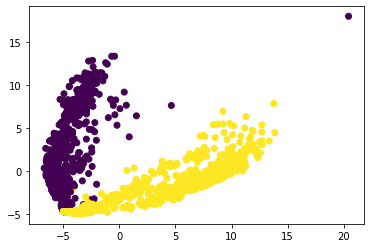

Mean test scores:
[0.         0.92779585 0.97210149 0.97559796 0.97630761 0.97761465]
Best C chosen:  100.0
[  0.98833476   0.          -5.92602091   2.08881687   8.06746035
  -8.81632329   0.02902658   1.66753788   2.26131648   1.39722501
   1.50399723   0.           5.79576492   0.          12.72799454
   0.95490202  -2.95112011  15.13869665 -11.72949845   0.
   0.           4.63820771   2.63210314  -8.92659515   2.78464954
  -6.83798425  -1.7404445   -4.86666151   0.           0.
   0.          -0.69806264   0.           0.          10.6411971
   1.52914133  -6.75773336   0.           3.05949061   0.
   0.           0.           0.09083808  -9.01474874  -1.57468103
   0.           1.10112393   0.           2.78894982   1.94855527]
LVs associated with classification of epithelial cell :
[12  4 34 14 17]


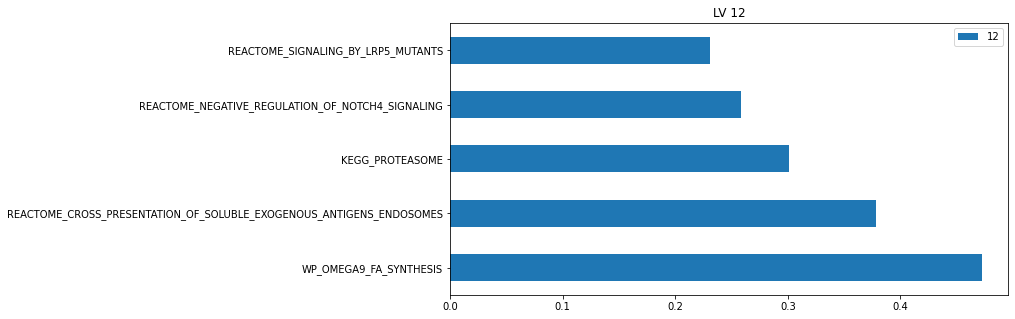

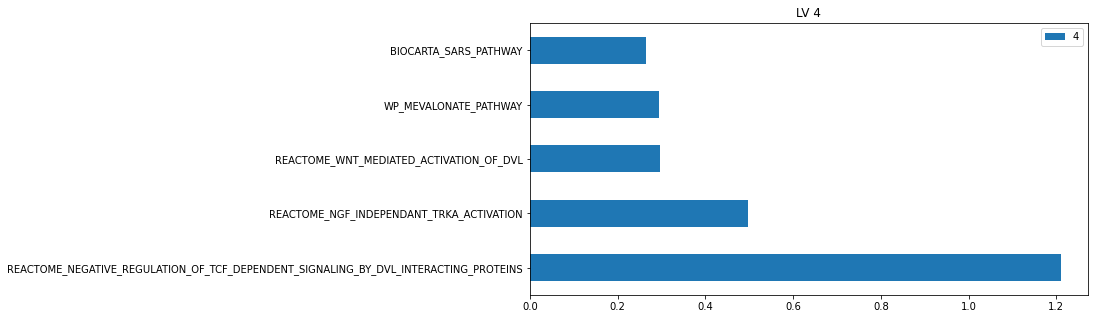

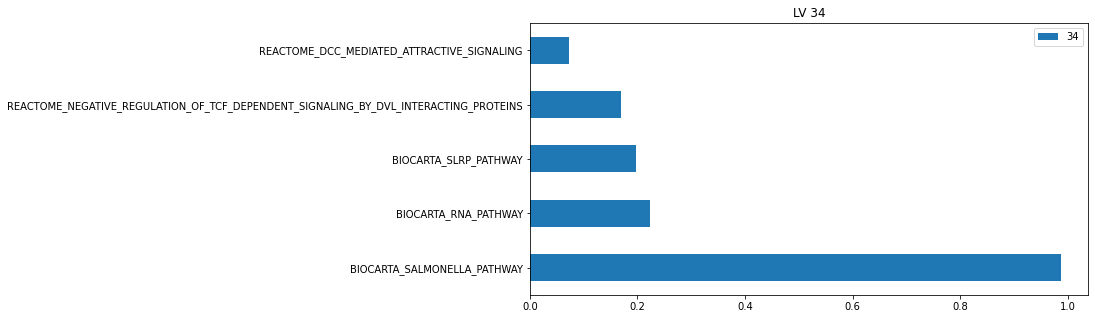

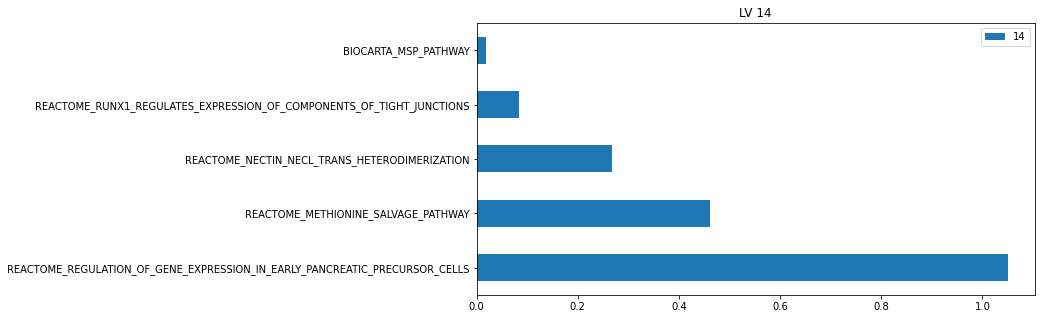

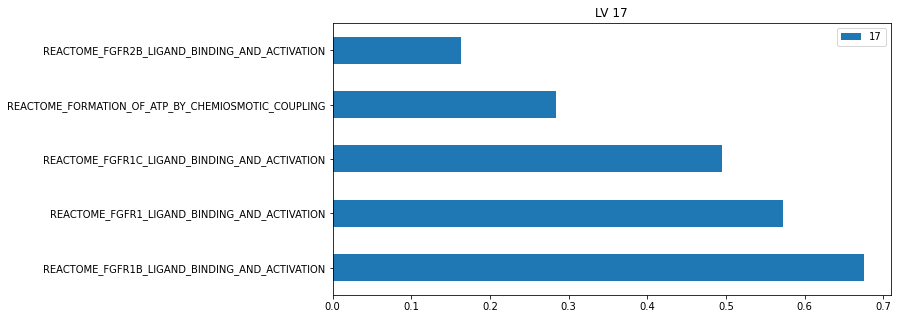

LVs associated with classification of T cell :
[18 43 23  5 25]


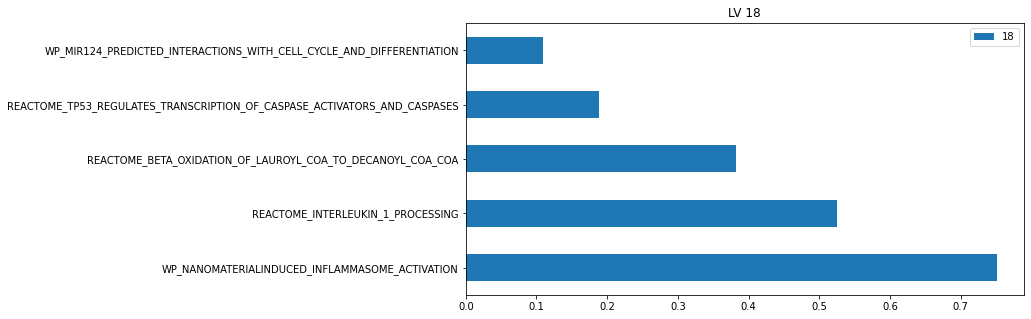

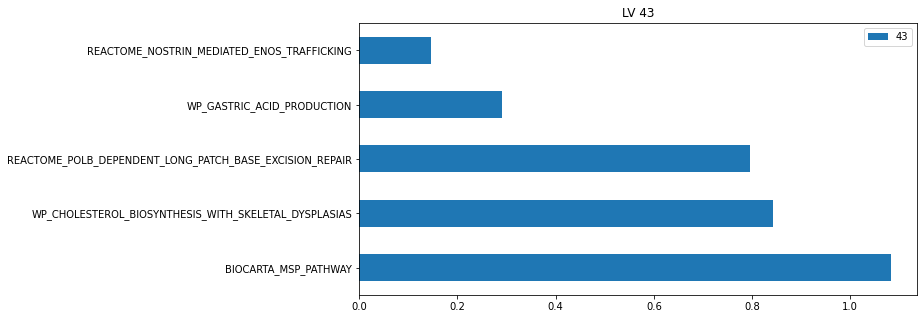

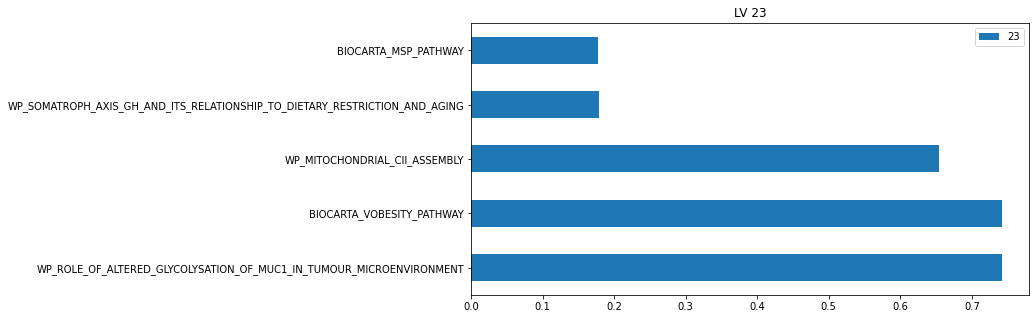

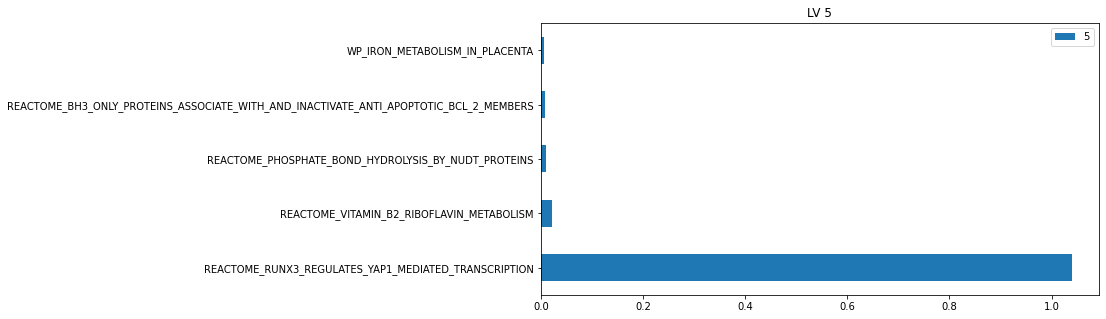

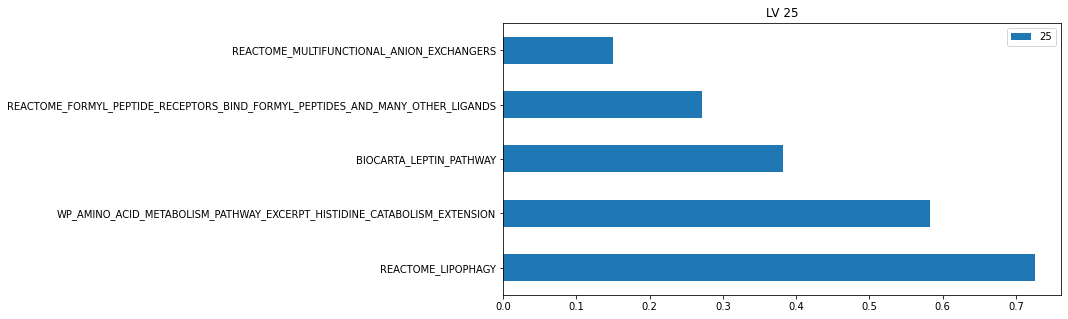

In [157]:
classify(Z,"epithelial cell", "T cell", model)